# Lesson 2: Convolutional Neural Networks

In this lesson, we will cover an approach to the [Cats vs. Dogs Kaggle Competition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition). Along the way, we will dig deeper into the architecture of a neural network. This includes learning how weights are initialized and optimized as well as the role of activation functions in neural networks. We will also finetune a pre-trained VGG 16 model and build a linear model in Keras.

Before we get to any of that, here are a few steps needed to enter a Kaggle Competition...

## Setting Up Kaggle

The following steps are needed to get an account, install Kaggle-CLI, and enter a competition:

1. **Create a Kaggle account.** You'll need a username and password when entering your competition submissions, so get an account that isn't linked to any social media. If you do opt to connect to a social media account, you can choose a username and password linked to your account by clicking "forgot password".
2. **Install Kaggle-CLI.** SSH into your instance, then enter: 
<br><br>
```pip install kaggle-cli```
<br><br>
3. **Enter a competition.** The competition name is "dogs-vs-cats-redux-kernels-edition".
<br><br>
```kg config -g -u username -p password -c competition```
<br><br>
4. **Accept the Competition's Terms and Conditions.** This can be done on the competition's Kaggle page. Attempting to download data for the competition before completing this step will yield an error. 
5. **Download the data.** Now that you've entered into the competition and accepted the terms and conditions, you can download the necessary data sets (train and test directories):
<br><br>
```kg download```
<br><br>
To unzip the folders, install ```unzip``` and unzip each file:
<br><br>
```sudo apt install unzip```
<br>
```unzip *.zip```
<br><br>
6. **Enter submission.** This is the last step. Your submission should be saved as a CSV file.
<br><br>
```kg submit submission -c competition -u username -p password -m “Enter submission description here.”```
<br>

Now that we've entered the competition and downloaded the necessary data sets, we can carry on with our submission. One thing to note here is the competition's evaluation metric, **log loss**.

### Log Loss

In information theory, binary entropy (a subset of categorical cross-entropy) is defined as the measure of uncertainty of the Bernoulli process with probability of success $y$. When considering the total distribution of the data set, the summation of the entropy must be included. This is how submissions are scored on the log loss, as defined [here](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition#evaluation):

\begin{equation*}
LogLoss =  -\frac{1}{n} \sum_{i=1}^n y_ilog(\hat{y_i}) + (1-y_i)log(1-\hat{y_i})
\end{equation*}

where $n$ is the number of images in the training set, $\hat{y_i}$ is the predicted probability of the image being of a dog, and $y_i$ is the true label of whether the image is of a dog (1) or cat (0).

As you may have already noticed, probability values of 0 or 1 will give undefined loss. Kaggle accomodates for this by offsetting zeros and ones by a very small amount. Therefore, by the way that it is calculated, log loss will yield extremely low for predictions that are confident and correct (p = 0.9999, label = 1) and drastically increase for those that are confident and incorrect (p = 0.0001, label = 1).

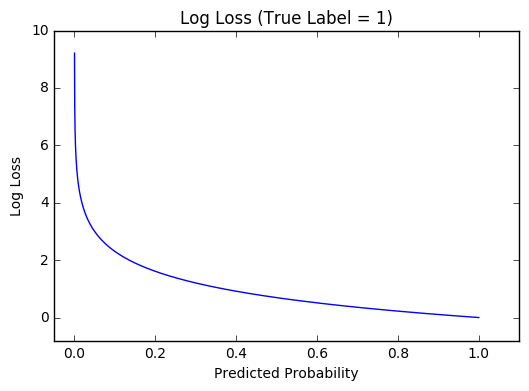

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

x = [i*.0001 for i in range(1,10000)]
y = [log_loss([1],[[i*.0001,1-(i*.0001)]],eps=1e-15) for i in range(1,10000,1)]

plt.plot(x, y)
plt.axis([-.05, 1.1, -.8, 10])
plt.title("Log Loss (True Label = 1)")
plt.xlabel("Predicted Probability")
plt.ylabel("Log Loss")

plt.show()

To avoid this issue, we can clip the range to lessen the log loss. This is done in my [Cats vs. Dogs Competition notebook](https://github.com/fdaham/fastai/blob/master/dogs_cats_kaggle.ipynb).

Now, back to CNNs...

## Visualizing and Understanding CNNs

We used a Convolutional Neural Network (CNN) in Lesson 1 to classify images of cats and dogs. But, what is a neural network? Vaguely put, it is a universal approximator used for architectures that have a high tolerance to error (which is why we use it for image recognition). Neural networks are, essentially, a collection, or series, of matrix products where an input is mapped to an output through matrix multiplication. 

For CNNs specifically, inputs (taken from training sets) are just arrays of pixel values. We map our input to weights (initialized randomly and later trained) in order to yield activation matrices, which we try to get as close as possible to our desired output through minimizing our loss function (a measure of how well our model fits empirical data). This is just one layer of the network. Below is an example of a network with just one input layer (first column), hidden layer (second column), and output (courtesy of [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap1.html)):

![image](http://i.imgur.com/Yz4Znws.png[/img)

One of the algorithms used in this network to minimize our loss function and optimize weights is called **gradient descent**. 

### Gradient Descent

Gradient descent uses initialized parameter values and iteratively takes the partial derivative of the loss function with respect to each parameter to minimize the loss. The parameters are updated by taking steps (i.e. a **learning rate**) in the direction opposite to the partial derivatives of the loss function. This process is done over the entire training data set, which exceeds the computational limits of a neural network.

**Stochastic Gradient Descent (SGD)** is possibly the most important algorithm to learn in deep learning. Instead of evaluating the loss function over the entire training data set, predictions are made on random data samples (or **mini batches**) and their true values are used to evaluate the loss function. This helps to avoid the compute-heavy issue that arises when using standard gradient descent.    

Here's an interesting question asked during lecture: what happens when you evaluate the loss function and reach a local minimum where the derivative is zero? This could almost never happen in a deep learning network as there are hundreds of millions of dimensions. The chance of each dimension sharing the same minimum is nearly impossible. 

After one random mini batch pass, our weights are updated and we can proceed to the next mini batch. So, how are the weights updated?

### Weight Optimization

As previously mentioned, **weight optimization** takes all the weights of the filters of a network and updates them in the opposite direction of the gradient. Keras, like most deep learning libraries, handles weight optimization for us, so we don't need to worry about weight initialization. However, **weight initialization** is important because, if weights are set to be too small or too large, their signals will either shrink or blow up through each layer of the network to the point where they become useless. Either case will inevitably happen when randomly initializing weights (done for symmetry purposes) for each filter in the network. To avoid this issue, we set our initial weight values using a method called **Xavier Initialization**. 

We use Xavier Initialization to initialize our weights to adequately scale our output. We start by setting our initial weight matrices, $W_{i}$, to a distribution (typically Gaussian or uniform) with a mean of zero and variance, $V$, of: 

\begin{equation*}
V(W_{i}) = \frac{1}{n_{in}}
\end{equation*}

where $n_{in}$ is the number of input vectors making up the $W_{i}$ initialization distribution. You can set the dimensions of the weight matrices to be anything, but you’re given an input and output matrix. Therefore, the dimensions of the input matrix should match that of the output matrix. Note: if input $A$ is an $n×m$ matrix and ouput $B$ is an $m×p$ matrix, $AB$ is an $n×p$ matrix where $n$, $m$, $p$  are all positive integers. Here's a short summary of the derivation:

Our output matrix ($Y$) is the dot product of our weight ($W$) and input ($X$) matrices:

\begin{equation*}
Y = W_{1}X_{1} + W_{2}X_{2} + ... + W_{n}X_{n}
\end{equation*}
 
The variance of the input is $Var(X_{i}) = E[X_{i}^{2}] + {E[X_{i}]}^2$, where $E[X_{i}]$ is the expected value of the squared deviation from the mean. Similarly, the variance of the weight matrix is $Var(W_{i}) = E[W_{i}^{2}] + {E[W_{i}]}^2$. $W$ and $X$ are independent of one another, so the variance of their dot product is:

\begin{equation*}
Var(W_{i}X_{i}) = {[E(W_{i})]}^{2}Var(X_{i}) + {[E(X_{i})]}^{2}Var(W_{i}) + Var(W_{i})Var(X_{i})
\end{equation*}

If our inputs and weights both have a zero mean, our combined variance simplifies to:

\begin{equation*}
Var(W_{i}X_{i}) = Var(W_{i})Var(X_{i})
\end{equation*}

So, the variance of our output is:

\begin{equation*}
Var(Y) = Var(W_{1}X_{1} + W_{2}X_{2} + ... + W_{n}X_{n}) = nVar(W_{i})Var(X_{i}) 
\end{equation*}

We want the variance of our input and output to be the same, so this simplifies to $nVar(W_{i}) = 1$, or: 

\begin{equation*}
Var(W_{i}) = \frac{1}{n}
\end{equation*}

Here, *$n = n_{in}$*. $V(W_{i})$ can also be derived from backpropagation (training multiple layers of a model--introduced later in this lesson), which gives $n_{in} = n_{out}$. Taking the average of the two yields:

\begin{equation*}
V(W_{i}) = \frac{2}{n_{in} + n_{out}}
\end{equation*}  

Now that we know how to initialize our weights, how do we update (or optimize) them for each filter in our network? This is done by minimizing our loss function with respect to each weight parameter. You can visualize the loss below (image taken from [a Beginner's Guide to Understanding Convolutional Neural Networks](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/), a post that I found very helpful):

![img](http://i.imgur.com/seZGfcn.png[/img])

This is just a simple example of how loss varies as a function of two weights. To minimize loss, *$L$*, the weights must be updated by taking the derivative of the loss function with respect to both parameters and taking steps in the direction opposite the gradient:

\begin{equation*}
W = W_{in} - l \frac{dL}{dW}
\end{equation*}

where *$l$* is the learning rate--a parameter we optimally set. The learning rate allows the model to converge on an optimal set of weights in a short amount of time. However, setting the rate too high could result in large steps that may never converge to the optimal point.

Now that we know how to initialize and optimize our weights through the SGD algorithm, let's test what we know by building a simple linear model in Keras.

### Building a Linear Model

Here, we'll build a simple linear model trained using the 1,000 predictions from the Imagenet model, where all the images are our inputs and the labels (dog or cat) are our target outputs. Let's import the necessary libraries first:

In [6]:
from __future__ import division,print_function
import os, json
from glob import glob
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots, get_batches, plot_confusion_matrix, get_data

In [7]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

Each dense layer, as we've discussed in the previous lesson, is a linear model followed by an activation function (which we'll discuss more later). A **linear model** is a model where each row (or layer) is calculated as the sum of the dot product of the row and weights. The weights are learned from the data and the same weights are mapped to each row. 

Let's observe how a linear model works by seeing how Keras implements gradient descent in the context of linear regression. To do this, we need data that we know is linearly related. In this example, we will be using $y(x) = 2x_{1} + 3x_{2} + 1$, where the input is $x = [x_{1} x_{2}]$ and the output is $y$. 

In [8]:
x = random((30,2))
y = np.dot(x, [2., 3.]) + 1.

Now, we can create our simple linear model, ```lm```, in Keras. Here, we pass our inputs and expected outputs (```x``` and ```y```) so that Keras can initialize some form of random weights. The model is then optimized using SGD to minimize our loss function--in this case, **Mean Squared Error (```mse```)**--with a learning rate of 0.1. 

In [29]:
lm = Sequential([ Dense(1, input_shape=(2,)) ])
lm.compile(optimizer=SGD(lr=0.1), loss='mse')

The weights have now been trained. The next step is to evaluate our loss. Obviously, we're looking for a very small number here... 

In [30]:
lm.evaluate(x, y, verbose=0)

19.739252090454102

This is not what we expected... To iteratively pass our ```x``` and ```y``` pairs through the SGD algorithm to evaluate the loss function and update the parameters, we'll call the ```fit``` function. We run this through 5 epochs before re-evaluating our predictions. Notice how the loss is minimized after each epoch.

In [31]:
lm.fit(x, y, nb_epoch=5, batch_size=1)

Epoch 1/5
30/30 [==============================] - 0s - loss: 1.8141     
Epoch 2/5
30/30 [==============================] - 0s - loss: 0.1805     
Epoch 3/5
30/30 [==============================] - 0s - loss: 0.0959     
Epoch 4/5
30/30 [==============================] - 0s - loss: 0.0472     
Epoch 5/5
30/30 [==============================] - 0s - loss: 0.0297     


In [32]:
lm.evaluate(x, y, verbose=0)

0.015679962933063507

That works! For confirmation, we can see that our weights have been optimized so that, after fitting, they're close to the weights we used to calculate ```y``` (2.0, 3.0, and 1.0):

In [33]:
lm.get_weights()

[array([[ 1.6216],
        [ 2.7918]], dtype=float32), array([ 1.3504], dtype=float32)]

#### Training the Linear Model

So far, we've trained a linear model from a pre-trained model's output. Now, we can apply what we've learned to the Cats vs Dogs Kaggle competition. That is, we want to train a simple linear model to take the 1,000 predictions (learned from Kaggle data) as inputs and return the *dog* or *cat* labels as outputs. To do this, let's start with a few configuration steps: 

In [34]:
path = "data/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

Finding the max batch size is a matter of trial and error. Here, we're able to use a batch size of 100 to start for our VGG 16 model:

In [35]:
batch_size=100

In [36]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

Let's start by grabbing our training and validation batches:

In [37]:
# use batch size of 1 since we're just doing preprocessing on the CPU
val_batches = get_batches(path+'valid', shuffle=False, batch_size=1)
batches = get_batches(path+'train', shuffle=False, batch_size=1)

Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.


Here, we'll load and save the preprocessed arrays using ```bcolz``` to avoid loading and resizing the images every time we use them. Using ```bcolz``` to save and load arrays simplifies the space and time complexity of our network.

In [38]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

Let's join the arrays in all the batches for the validation and training sets and load them so that we don't have to recalculate them later:

In [41]:
trn_data = get_data(path+'train')
val_data = get_data(path+'valid')

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [42]:
save_array(model_path+'train_data.bc', trn_data)
save_array(model_path+'valid_data.bc', val_data)

It seems that I don't have enough RAM to load the ```trn_data``` array into memory. So, instead, ```bcolz.open()``` was used to mmap (or memory-map) the file.

In [51]:
trn_data = bcolz.open(model_path+'train_data.bc', mode='r')
val_data = load_array(model_path+'valid_data.bc')

Our classes are returned by Keras in an array. Here, we convert them to multi-dimensional arrays for one-hot encoding:

In [56]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [57]:
val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

The 1,000 Imagenet predictions from VGG16 will be the features for our linear model. We can also load these features to avoid recalculating them in the future:

In [58]:
trn_features = model.predict(trn_data, batch_size=batch_size)
val_features = model.predict(val_data, batch_size=batch_size)

In [59]:
save_array(model_path+'train_lastlayer_features.bc', trn_features)
save_array(model_path+'valid_lastlayer_features.bc', val_features)

In [60]:
trn_features = load_array(model_path+'train_lastlayer_features.bc')
val_features = load_array(model_path+'valid_lastlayer_features.bc')

Now, we can define our linear model, just like we did earlier, and fit it:

In [61]:
# 1000 inputs (saved features) and 2 outputs (dog and cat)
lm = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [62]:
batch_size=64

In [63]:
lm.fit(trn_features, trn_labels, nb_epoch=3, batch_size=batch_size, 
       validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 0s - loss: 0.0975 - acc: 0.9673 - val_loss: 0.0885 - val_acc: 0.9730
Epoch 2/3
23000/23000 [==============================] - 0s - loss: 0.0780 - acc: 0.9752 - val_loss: 0.0926 - val_acc: 0.9740
Epoch 3/3
23000/23000 [==============================] - 0s - loss: 0.0789 - acc: 0.9769 - val_loss: 0.0968 - val_acc: 0.9745


We can achieve better results through a process called **finetuning**, as we've seen in the previous lesson. Before we get to that, we need to introduce **activation layers** and their role in neural networks.

### Activation Layers

As discussed before, neural networks are a series of matrix multiplications (or layers) that transform an input vector. If a network were to only be a sequence of matrix multiplications, it would not pass linear complexity and result in just a single matrix. But, this isn't the case for deep learning models. Deep learning model layers have nonlinear functions operated on the output from the previous layer. The resulting vector then becomes the input to the next layer, called **activation layers**. Every layer in VGG16 has an activation function, which tells Keras how to transform the output of a linear layer. Some common activation functions include tanh, sigmoid (```1/(1+exp(x))```), and rectified linear unit (ReLU, ```max(0,x)```), which is the most common activation function). 

We know activation functions exist in neural networks, but why? They help introduce nonlinearity to our network. ReLU is the most common activation function used in these networks because it has little effect on the accuracy of our model; we're just replacing all of our negative values with 0. 

The final layer of our model generally needs a different activation function to better represent our final output. For example, if our expected output is a one-hot encoded parameter, we want the values of our output vector to sum to one, where one value (or probability, since it's out of 1) is significantly larger than the rest. This way, we convert the greatest number to 1 and the rest to 0. The activation function that does this is **softmax**, defined as ```exp(x[i])/sum(exp(x))```.

#### Modifying the Model

Looking at the last layer of the VGG16 model, we can see that it's a dense layer that outputs 1,000 elements. Therefore, it seems redundant to stack another dense layer meant to find cats and dogs on top of one that's meant to find Imagenet categories. In that sense, we're limiting information by forcing the network to classify Imagenet categories before labeling our images as either being a cat or dog. So, let's just remove that last layer of the model. We'll train the model like before, but now we'll be removing the last layer and telling Keras to adjust the weights accordingly for the other layers since we aren't looking to learn new parameters.

In [64]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [65]:
model.pop()
for layer in model.layers: layer.trainable=False

Now that we removed the last layer, let's add our new final activation layer (```softmax```):

In [66]:
model.add(Dense(2, activation='softmax'))

We're now ready to compile our updated model and randomize our training batches to use the preprocessed images:

In [68]:
gen=image.ImageDataGenerator()
batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

Here, we define a simple function for our fitting models and use it to train our ```softmax``` layer. 

In [69]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=nb_epoch, 
                        validation_data=val_batches, nb_val_samples=val_batches.N)

In [70]:
opt = RMSprop(lr=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [75]:
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
23000/23000 [==============================] - 655s - loss: 0.3866 - acc: 0.9748 - val_loss: 0.3398 - val_acc: 0.9785
Epoch 2/2
23000/23000 [==============================] - 656s - loss: 0.3653 - acc: 0.9763 - val_loss: 0.3229 - val_acc: 0.9795


We always want to save our weights for later use:

In [76]:
model.save_weights(model_path+'finetune1.h5')

In [77]:
model.load_weights(model_path+'finetune1.h5')

In [78]:
model.evaluate(val_data, val_labels)

2000/2000 [==============================] - 54s    


[0.32286706900597312, 0.97950000000000004]

We've now successfully fine-tuned our new final layer and can do this for all of our dense layers, using the chain rule to calculate our gradients through a method called **backpropagation**.

### Introduction to Backpropagation

Stacking linear and non-linear (activation) layers is simply defining a convolution of functions. Each layer takes the output of the previous layer and uses it as its input. Therefore, we can calculate the derivative at any layer by simply multiplying the gradients of that layer and all of its following layers together. This use of the chain rule to allow us to rapidly calculate the derivatives of our model at any layer is referred to as backpropagation. Libraries like Theano, Tensorflow, and Keras already do this for us through automatic differentiation (AD). 

We can now apply this method to train the other layers of our network.

#### Training Multiple Layers in Keras

In [79]:
layers = model.layers
# Get the index of the first dense layer...
first_dense_idx = [index for index,layer in enumerate(layers) if type(layer) is Dense][0]
# ...and set this and all subsequent layers to trainable
for layer in layers[first_dense_idx:]: layer.trainable=True

We haven't changed our model, so there's no need to re-compile it, we just need to update the learning rate. Since we're training more layers and we've already optimized the last one, we should use a smaller rate.

In [80]:
K.set_value(opt.lr, 0.01)
fit_model(model, batches, val_batches, 3)

Epoch 1/3
23000/23000 [==============================] - 659s - loss: 0.3213 - acc: 0.9793 - val_loss: 0.2992 - val_acc: 0.9810
Epoch 2/3
23000/23000 [==============================] - 658s - loss: 0.3437 - acc: 0.9776 - val_loss: 0.2978 - val_acc: 0.9805
Epoch 3/3
23000/23000 [==============================] - 656s - loss: 0.3415 - acc: 0.9780 - val_loss: 0.3104 - val_acc: 0.9800


We have now fine-tuned all of our dense layers--all optimized for our data set. Notice how our training accuracy has increased using this method. Finally, let's save the weights for this updated model:

In [81]:
model.save_weights(model_path+'finetune2.h5')